In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/signlangdata.zip','r') as zip:
  zip.extractall()


In [3]:
! pip install keras


In [4]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


**Sample image display**

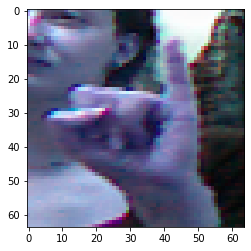

In [21]:

img_arr=cv2.imread('/content/dataset5/C/i/color_8_0027.png',cv2.COLOR_BGR2RGB)
img=cv2.resize(img_arr,(64,64))
plt.imshow(img)